By [Kevin Michalewicz](https://kevinmichalewicz.com) on April 2023

This notebook details how to pre-process antibody structures to obtain aligned normal mode correlation maps. After that, training and evaluation using the ANTIPASTI model is explained.

In [1]:
# General imports
import cv2
import itertools
import matplotlib.pyplot as plt
import numpy as np

from matplotlib.colors import CenteredNorm

# PyTorch-related libraries
from adabelief_pytorch import AdaBelief
from torch.nn import MSELoss
from torchmetrics import PearsonCorrCoef

# ANTIPASTI
from antipasti.model.model import ANTIPASTI
from antipasti.preprocessing.preprocessing import Preprocessing
from antipasti.utils.torch_utils import create_test_set, save_checkpoint, training_routine

# Pre-processing

In [2]:
modes = 30 # Number of normal modes to consider. Relevant if renew_maps is True
renew_maps = False # True to compute again all the normal mode correlation maps
renew_residues = False # True to retrieve again all the chain lengths 
mode = 'fully-extended' # Choose between 'fully-extended' and 'fully-cropped'
regions = 'heavy' # 'paired_hl' or 'heavy'
pathological = ['5omm', '1mj7', '1qfw', '1qyg', '3ifl', '3lrh', '3pp4', '3ru8', '3t0w', '3t0x', '4fqr', '4gxu', '4jfx', '4k3h', '4jfz', '4jg0', '4jg1', '4jn2', '4o4y', '4qxt', '4r3s', '4w6y', '4w6y', '5ies', '5ivn', '5j57', '5kvd', '5kzp', '5mes', '5nmv', '5sy8', '5t29', '5t5b', '5vag', '3etb', '3gkz', '3uze', '3uzq', '4f9l', '4gqp', '4r2g', '5c6t']

preprocessed_data = Preprocessing(modes=modes, regions=regions, pathological=pathological, renew_maps=renew_maps, renew_residues=renew_residues, mode=mode)

Let's plot some histograms to see the distributions of the chain lengths and the binding affinities.

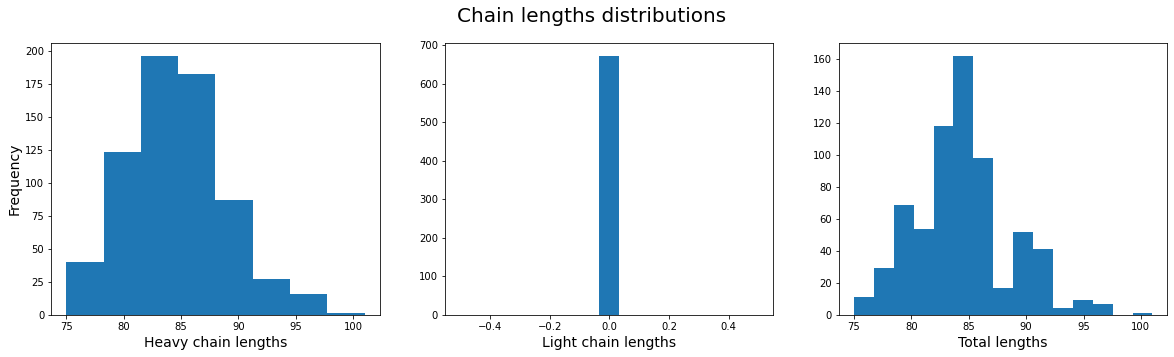

In [3]:
title_size = 20
font_size = 14

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 5))
fig.suptitle('Chain lengths distributions', size=title_size)
ax1.hist(preprocessed_data.heavy, 8)
ax2.hist(preprocessed_data.light, 15)
ax3.hist([sum(x) for x in zip(preprocessed_data.heavy, preprocessed_data.light)], 15)

# Changing plotting settings
ax1.set_ylabel('Frequency', size=font_size)
ax1.set_xlabel('Heavy chain lengths', size=font_size)
ax2.set_xlabel('Light chain lengths', size=font_size)
ax3.set_xlabel('Total lengths', size=font_size)

plt.show()

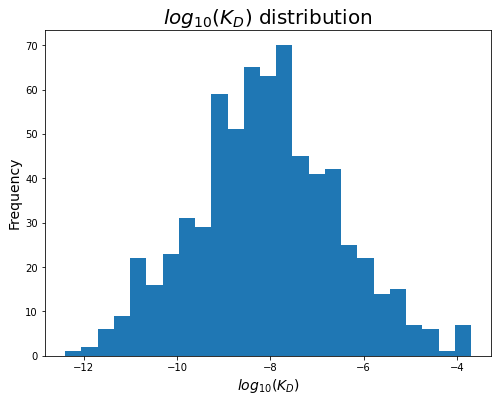

In [4]:
fig = plt.figure(figsize=(8, 6))
plt.title('$log_{10}(K_D)$ distribution', size=title_size)
plt.hist(preprocessed_data.train_y, 25)
plt.xlabel('$log_{10}(K_D)$', size=font_size)
plt.ylabel('Frequency', size=font_size)
plt.show()

A sample normal mode correlation map before and after adding the blank pixels.

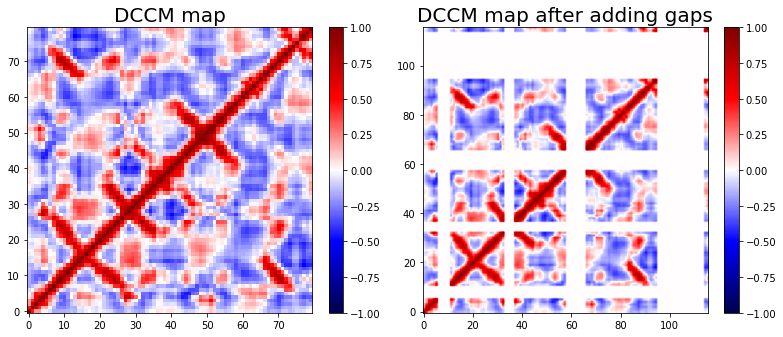

In [5]:
input_shape = preprocessed_data.train_x.shape[-1]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 5.25))
im1 = ax1.imshow(preprocessed_data.raw_imgs[74], origin='lower', cmap='seismic', norm=CenteredNorm())
im2 = ax2.imshow(preprocessed_data.train_x[74].reshape(input_shape, input_shape), origin='lower', cmap='seismic', norm=CenteredNorm())

ax1.set_title('DCCM map', size=title_size)
ax2.set_title('DCCM map after adding gaps', size=title_size)

plt.colorbar(im1, ax=ax1, fraction=0.045)
plt.colorbar(im2, ax=ax2, fraction=0.045)

ax1.tick_params(axis='both', which='major', labelsize=10)
ax2.tick_params(axis='both', which='major', labelsize=10)

plt.show()

In [870]:
# The test set is generated
train_x, test_x, train_y, test_y = create_test_set(preprocessed_data.train_x, preprocessed_data.train_y)

In [871]:
# Hyperparameters
n_filters = 1
filter_size = 4
pooling_size = 2
learning_rate = 0.00027253018778843 * 2.5

# Defining the model, optimiser and loss function
model = ANTIPASTI(n_filters=n_filters, filter_size=filter_size, pooling_size=pooling_size, input_shape=input_shape)
criterion = MSELoss() #-PearsonCorrCoef()
optimiser = AdaBelief(model.parameters(), lr=learning_rate, eps=1e-8, print_change_log=False) 

print(model)

Weight decoupling enabled in AdaBelief
Rectification enabled in AdaBelief
ANTIPASTI(
  (conv1): Conv2d(1, 1, kernel_size=(4, 4), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropit): Dropout(p=0.05, inplace=False)
  (relu): ReLU()
  (fc1): Linear(in_features=3136, out_features=1, bias=False)
)


In [872]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [873]:
count_parameters(model)

3153

In [874]:
#{'learning_rate': 0.00027253018778843, 'n_max_epochs': 65, 'pooling_size': 1, 'filter_size': 4, 'n_filters': 4}
#{'learning_rate': 0.0008657756272162166, 'n_max_epochs': 82, 'pooling_size': 1, 'filter_size': 5, 'n_filters': 1}. Best is trial 30 with value: 1.0617385705312092.

# Training

In [875]:
train_losses = []
test_losses = []

In [699]:
test_x = np.delete(test_x, 0, 0)
test_x = np.delete(test_x, 11, 0)
test_y = np.delete(test_y, 0, 0)
test_y = np.delete(test_y, 11, 0)

In [876]:
#test_x = np.delete(test_x, 12, 0)
#test_y = np.delete(test_y, 12, 0)

In [964]:
n_max_epochs = 250
max_corr = 0.87
batch_size = 32

train_loss, test_loss, inter_filter, y_test, output_test = training_routine(model, criterion, optimiser, train_x, test_x, train_y, test_y, n_max_epochs=n_max_epochs, max_corr=max_corr, batch_size=batch_size)

# Saving the losses
train_losses.extend(train_loss)
test_losses.extend(test_loss)

tensor([[-9.2708]], grad_fn=<MmBackward0>)
tensor([[-11.1675]])
------------------------
tensor([[-7.4291]], grad_fn=<MmBackward0>)
tensor([[-7.7212]])
------------------------
tensor([[-7.8396]], grad_fn=<MmBackward0>)
tensor([[-7.2757]])
------------------------
tensor([[-7.6404]], grad_fn=<MmBackward0>)
tensor([[-6.3809]])
------------------------
tensor([[-7.6526]], grad_fn=<MmBackward0>)
tensor([[-7.0773]])
------------------------
tensor([[-9.3312]], grad_fn=<MmBackward0>)
tensor([[-9.5229]])
------------------------
tensor([[-8.0515]], grad_fn=<MmBackward0>)
tensor([[-8.]])
------------------------
tensor([[-8.4788]], grad_fn=<MmBackward0>)
tensor([[-8.4473]])
------------------------
tensor([[-7.8568]], grad_fn=<MmBackward0>)
tensor([[-8.6021]])
------------------------
tensor([[-6.6398]], grad_fn=<MmBackward0>)
tensor([[-5.9208]])
------------------------
tensor([[-6.7175]], grad_fn=<MmBackward0>)
tensor([[-6.2291]])
------------------------
tensor([[-7.0383]], grad_fn=<MmBack

tensor([[-8.3275]], grad_fn=<MmBackward0>)
tensor([[-11.1675]])
------------------------
tensor([[-7.6681]], grad_fn=<MmBackward0>)
tensor([[-7.7212]])
------------------------
tensor([[-7.3493]], grad_fn=<MmBackward0>)
tensor([[-7.2757]])
------------------------
tensor([[-8.2183]], grad_fn=<MmBackward0>)
tensor([[-6.3809]])
------------------------
tensor([[-6.3902]], grad_fn=<MmBackward0>)
tensor([[-7.0773]])
------------------------
tensor([[-9.2407]], grad_fn=<MmBackward0>)
tensor([[-9.5229]])
------------------------
tensor([[-8.3270]], grad_fn=<MmBackward0>)
tensor([[-8.]])
------------------------
tensor([[-8.4044]], grad_fn=<MmBackward0>)
tensor([[-8.4473]])
------------------------
tensor([[-9.1825]], grad_fn=<MmBackward0>)
tensor([[-8.6021]])
------------------------
tensor([[-6.3976]], grad_fn=<MmBackward0>)
tensor([[-5.9208]])
------------------------
tensor([[-6.6934]], grad_fn=<MmBackward0>)
tensor([[-6.2291]])
------------------------
tensor([[-7.7078]], grad_fn=<MmBack

tensor([[-8.9148]], grad_fn=<MmBackward0>)
tensor([[-11.1675]])
------------------------
tensor([[-8.1125]], grad_fn=<MmBackward0>)
tensor([[-7.7212]])
------------------------
tensor([[-7.3167]], grad_fn=<MmBackward0>)
tensor([[-7.2757]])
------------------------
tensor([[-8.3174]], grad_fn=<MmBackward0>)
tensor([[-6.3809]])
------------------------
tensor([[-7.3577]], grad_fn=<MmBackward0>)
tensor([[-7.0773]])
------------------------
tensor([[-9.5621]], grad_fn=<MmBackward0>)
tensor([[-9.5229]])
------------------------
tensor([[-8.2171]], grad_fn=<MmBackward0>)
tensor([[-8.]])
------------------------
tensor([[-8.4454]], grad_fn=<MmBackward0>)
tensor([[-8.4473]])
------------------------
tensor([[-8.3940]], grad_fn=<MmBackward0>)
tensor([[-8.6021]])
------------------------
tensor([[-6.7288]], grad_fn=<MmBackward0>)
tensor([[-5.9208]])
------------------------
tensor([[-6.6029]], grad_fn=<MmBackward0>)
tensor([[-6.2291]])
------------------------
tensor([[-8.0048]], grad_fn=<MmBack

tensor([[-9.3454]], grad_fn=<MmBackward0>)
tensor([[-11.1675]])
------------------------
tensor([[-8.0646]], grad_fn=<MmBackward0>)
tensor([[-7.7212]])
------------------------
tensor([[-7.2504]], grad_fn=<MmBackward0>)
tensor([[-7.2757]])
------------------------
tensor([[-8.1087]], grad_fn=<MmBackward0>)
tensor([[-6.3809]])
------------------------
tensor([[-6.4110]], grad_fn=<MmBackward0>)
tensor([[-7.0773]])
------------------------
tensor([[-9.6521]], grad_fn=<MmBackward0>)
tensor([[-9.5229]])
------------------------
tensor([[-8.7382]], grad_fn=<MmBackward0>)
tensor([[-8.]])
------------------------
tensor([[-8.3523]], grad_fn=<MmBackward0>)
tensor([[-8.4473]])
------------------------
tensor([[-8.4823]], grad_fn=<MmBackward0>)
tensor([[-8.6021]])
------------------------
tensor([[-6.4504]], grad_fn=<MmBackward0>)
tensor([[-5.9208]])
------------------------
tensor([[-6.7160]], grad_fn=<MmBackward0>)
tensor([[-6.2291]])
------------------------
tensor([[-7.7005]], grad_fn=<MmBack

tensor([[-9.1883]], grad_fn=<MmBackward0>)
tensor([[-11.1675]])
------------------------
tensor([[-7.5390]], grad_fn=<MmBackward0>)
tensor([[-7.7212]])
------------------------
tensor([[-6.9360]], grad_fn=<MmBackward0>)
tensor([[-7.2757]])
------------------------
tensor([[-8.3937]], grad_fn=<MmBackward0>)
tensor([[-6.3809]])
------------------------
tensor([[-7.1062]], grad_fn=<MmBackward0>)
tensor([[-7.0773]])
------------------------
tensor([[-9.6693]], grad_fn=<MmBackward0>)
tensor([[-9.5229]])
------------------------
tensor([[-8.1014]], grad_fn=<MmBackward0>)
tensor([[-8.]])
------------------------
tensor([[-7.8450]], grad_fn=<MmBackward0>)
tensor([[-8.4473]])
------------------------
tensor([[-9.0775]], grad_fn=<MmBackward0>)
tensor([[-8.6021]])
------------------------
tensor([[-6.4078]], grad_fn=<MmBackward0>)
tensor([[-5.9208]])
------------------------
tensor([[-6.8137]], grad_fn=<MmBackward0>)
tensor([[-6.2291]])
------------------------
tensor([[-6.7188]], grad_fn=<MmBack

tensor([[-9.4098]], grad_fn=<MmBackward0>)
tensor([[-11.1675]])
------------------------
tensor([[-7.4718]], grad_fn=<MmBackward0>)
tensor([[-7.7212]])
------------------------
tensor([[-7.1194]], grad_fn=<MmBackward0>)
tensor([[-7.2757]])
------------------------
tensor([[-8.3874]], grad_fn=<MmBackward0>)
tensor([[-6.3809]])
------------------------
tensor([[-7.3644]], grad_fn=<MmBackward0>)
tensor([[-7.0773]])
------------------------
tensor([[-9.1698]], grad_fn=<MmBackward0>)
tensor([[-9.5229]])
------------------------
tensor([[-7.9058]], grad_fn=<MmBackward0>)
tensor([[-8.]])
------------------------
tensor([[-9.1441]], grad_fn=<MmBackward0>)
tensor([[-8.4473]])
------------------------
tensor([[-7.5281]], grad_fn=<MmBackward0>)
tensor([[-8.6021]])
------------------------
tensor([[-6.3070]], grad_fn=<MmBackward0>)
tensor([[-5.9208]])
------------------------
tensor([[-6.5220]], grad_fn=<MmBackward0>)
tensor([[-6.2291]])
------------------------
tensor([[-7.3882]], grad_fn=<MmBack

tensor([[-8.7031]], grad_fn=<MmBackward0>)
tensor([[-11.1675]])
------------------------
tensor([[-7.9063]], grad_fn=<MmBackward0>)
tensor([[-7.7212]])
------------------------
tensor([[-7.7510]], grad_fn=<MmBackward0>)
tensor([[-7.2757]])
------------------------
tensor([[-7.6172]], grad_fn=<MmBackward0>)
tensor([[-6.3809]])
------------------------
tensor([[-5.8193]], grad_fn=<MmBackward0>)
tensor([[-7.0773]])
------------------------
tensor([[-8.9763]], grad_fn=<MmBackward0>)
tensor([[-9.5229]])
------------------------
tensor([[-8.6808]], grad_fn=<MmBackward0>)
tensor([[-8.]])
------------------------
tensor([[-8.6081]], grad_fn=<MmBackward0>)
tensor([[-8.4473]])
------------------------
tensor([[-8.3739]], grad_fn=<MmBackward0>)
tensor([[-8.6021]])
------------------------
tensor([[-6.5233]], grad_fn=<MmBackward0>)
tensor([[-5.9208]])
------------------------
tensor([[-7.4556]], grad_fn=<MmBackward0>)
tensor([[-6.2291]])
------------------------
tensor([[-7.6080]], grad_fn=<MmBack

tensor([[-8.8465]], grad_fn=<MmBackward0>)
tensor([[-11.1675]])
------------------------
tensor([[-8.0442]], grad_fn=<MmBackward0>)
tensor([[-7.7212]])
------------------------
tensor([[-7.3472]], grad_fn=<MmBackward0>)
tensor([[-7.2757]])
------------------------
tensor([[-7.8554]], grad_fn=<MmBackward0>)
tensor([[-6.3809]])
------------------------
tensor([[-7.3826]], grad_fn=<MmBackward0>)
tensor([[-7.0773]])
------------------------
tensor([[-9.2486]], grad_fn=<MmBackward0>)
tensor([[-9.5229]])
------------------------
tensor([[-8.1399]], grad_fn=<MmBackward0>)
tensor([[-8.]])
------------------------
tensor([[-8.5617]], grad_fn=<MmBackward0>)
tensor([[-8.4473]])
------------------------
tensor([[-8.3726]], grad_fn=<MmBackward0>)
tensor([[-8.6021]])
------------------------
tensor([[-7.2106]], grad_fn=<MmBackward0>)
tensor([[-5.9208]])
------------------------
tensor([[-7.0902]], grad_fn=<MmBackward0>)
tensor([[-6.2291]])
------------------------
tensor([[-7.4724]], grad_fn=<MmBack

tensor([[-8.9956]], grad_fn=<MmBackward0>)
tensor([[-11.1675]])
------------------------
tensor([[-7.5973]], grad_fn=<MmBackward0>)
tensor([[-7.7212]])
------------------------
tensor([[-7.0472]], grad_fn=<MmBackward0>)
tensor([[-7.2757]])
------------------------
tensor([[-7.8669]], grad_fn=<MmBackward0>)
tensor([[-6.3809]])
------------------------
tensor([[-7.3087]], grad_fn=<MmBackward0>)
tensor([[-7.0773]])
------------------------
tensor([[-9.4233]], grad_fn=<MmBackward0>)
tensor([[-9.5229]])
------------------------
tensor([[-7.8785]], grad_fn=<MmBackward0>)
tensor([[-8.]])
------------------------
tensor([[-8.6385]], grad_fn=<MmBackward0>)
tensor([[-8.4473]])
------------------------
tensor([[-8.2166]], grad_fn=<MmBackward0>)
tensor([[-8.6021]])
------------------------
tensor([[-6.9499]], grad_fn=<MmBackward0>)
tensor([[-5.9208]])
------------------------
tensor([[-7.0634]], grad_fn=<MmBackward0>)
tensor([[-6.2291]])
------------------------
tensor([[-7.5801]], grad_fn=<MmBack

tensor([[-9.2097]], grad_fn=<MmBackward0>)
tensor([[-11.1675]])
------------------------
tensor([[-7.7158]], grad_fn=<MmBackward0>)
tensor([[-7.7212]])
------------------------
tensor([[-7.7601]], grad_fn=<MmBackward0>)
tensor([[-7.2757]])
------------------------
tensor([[-8.2406]], grad_fn=<MmBackward0>)
tensor([[-6.3809]])
------------------------
tensor([[-6.2281]], grad_fn=<MmBackward0>)
tensor([[-7.0773]])
------------------------
tensor([[-9.3256]], grad_fn=<MmBackward0>)
tensor([[-9.5229]])
------------------------
tensor([[-8.3097]], grad_fn=<MmBackward0>)
tensor([[-8.]])
------------------------
tensor([[-8.3996]], grad_fn=<MmBackward0>)
tensor([[-8.4473]])
------------------------
tensor([[-9.0776]], grad_fn=<MmBackward0>)
tensor([[-8.6021]])
------------------------
tensor([[-6.8098]], grad_fn=<MmBackward0>)
tensor([[-5.9208]])
------------------------
tensor([[-6.5594]], grad_fn=<MmBackward0>)
tensor([[-6.2291]])
------------------------
tensor([[-7.8065]], grad_fn=<MmBack

tensor([[-8.9710]], grad_fn=<MmBackward0>)
tensor([[-11.1675]])
------------------------
tensor([[-7.7684]], grad_fn=<MmBackward0>)
tensor([[-7.7212]])
------------------------
tensor([[-7.1066]], grad_fn=<MmBackward0>)
tensor([[-7.2757]])
------------------------
tensor([[-7.7177]], grad_fn=<MmBackward0>)
tensor([[-6.3809]])
------------------------
tensor([[-7.4882]], grad_fn=<MmBackward0>)
tensor([[-7.0773]])
------------------------
tensor([[-9.6214]], grad_fn=<MmBackward0>)
tensor([[-9.5229]])
------------------------
tensor([[-8.0948]], grad_fn=<MmBackward0>)
tensor([[-8.]])
------------------------
tensor([[-8.2650]], grad_fn=<MmBackward0>)
tensor([[-8.4473]])
------------------------
tensor([[-8.2351]], grad_fn=<MmBackward0>)
tensor([[-8.6021]])
------------------------
tensor([[-6.1691]], grad_fn=<MmBackward0>)
tensor([[-5.9208]])
------------------------
tensor([[-7.8039]], grad_fn=<MmBackward0>)
tensor([[-6.2291]])
------------------------
tensor([[-7.2487]], grad_fn=<MmBack

tensor([[-9.1656]], grad_fn=<MmBackward0>)
tensor([[-11.1675]])
------------------------
tensor([[-7.4673]], grad_fn=<MmBackward0>)
tensor([[-7.7212]])
------------------------
tensor([[-6.9362]], grad_fn=<MmBackward0>)
tensor([[-7.2757]])
------------------------
tensor([[-8.5422]], grad_fn=<MmBackward0>)
tensor([[-6.3809]])
------------------------
tensor([[-7.1646]], grad_fn=<MmBackward0>)
tensor([[-7.0773]])
------------------------
tensor([[-9.3070]], grad_fn=<MmBackward0>)
tensor([[-9.5229]])
------------------------
tensor([[-8.0828]], grad_fn=<MmBackward0>)
tensor([[-8.]])
------------------------
tensor([[-9.1642]], grad_fn=<MmBackward0>)
tensor([[-8.4473]])
------------------------
tensor([[-9.0996]], grad_fn=<MmBackward0>)
tensor([[-8.6021]])
------------------------
tensor([[-6.2122]], grad_fn=<MmBackward0>)
tensor([[-5.9208]])
------------------------
tensor([[-6.8846]], grad_fn=<MmBackward0>)
tensor([[-6.2291]])
------------------------
tensor([[-7.7434]], grad_fn=<MmBack

tensor([[-8.3361]], grad_fn=<MmBackward0>)
tensor([[-11.1675]])
------------------------
tensor([[-7.6097]], grad_fn=<MmBackward0>)
tensor([[-7.7212]])
------------------------
tensor([[-6.9003]], grad_fn=<MmBackward0>)
tensor([[-7.2757]])
------------------------
tensor([[-8.5998]], grad_fn=<MmBackward0>)
tensor([[-6.3809]])
------------------------
tensor([[-7.4668]], grad_fn=<MmBackward0>)
tensor([[-7.0773]])
------------------------
tensor([[-9.5968]], grad_fn=<MmBackward0>)
tensor([[-9.5229]])
------------------------
tensor([[-7.5581]], grad_fn=<MmBackward0>)
tensor([[-8.]])
------------------------
tensor([[-9.1493]], grad_fn=<MmBackward0>)
tensor([[-8.4473]])
------------------------
tensor([[-8.4960]], grad_fn=<MmBackward0>)
tensor([[-8.6021]])
------------------------
tensor([[-6.3290]], grad_fn=<MmBackward0>)
tensor([[-5.9208]])
------------------------
tensor([[-7.2930]], grad_fn=<MmBackward0>)
tensor([[-6.2291]])
------------------------
tensor([[-7.3028]], grad_fn=<MmBack

tensor([[-8.7790]], grad_fn=<MmBackward0>)
tensor([[-11.1675]])
------------------------
tensor([[-7.9236]], grad_fn=<MmBackward0>)
tensor([[-7.7212]])
------------------------
tensor([[-7.8240]], grad_fn=<MmBackward0>)
tensor([[-7.2757]])
------------------------
tensor([[-7.9927]], grad_fn=<MmBackward0>)
tensor([[-6.3809]])
------------------------
tensor([[-7.3812]], grad_fn=<MmBackward0>)
tensor([[-7.0773]])
------------------------
tensor([[-9.6125]], grad_fn=<MmBackward0>)
tensor([[-9.5229]])
------------------------
tensor([[-8.1061]], grad_fn=<MmBackward0>)
tensor([[-8.]])
------------------------
tensor([[-9.0667]], grad_fn=<MmBackward0>)
tensor([[-8.4473]])
------------------------
tensor([[-8.3596]], grad_fn=<MmBackward0>)
tensor([[-8.6021]])
------------------------
tensor([[-6.5499]], grad_fn=<MmBackward0>)
tensor([[-5.9208]])
------------------------
tensor([[-6.4519]], grad_fn=<MmBackward0>)
tensor([[-6.2291]])
------------------------
tensor([[-6.9186]], grad_fn=<MmBack

tensor([[-9.1873]], grad_fn=<MmBackward0>)
tensor([[-11.1675]])
------------------------
tensor([[-8.0767]], grad_fn=<MmBackward0>)
tensor([[-7.7212]])
------------------------
tensor([[-7.1080]], grad_fn=<MmBackward0>)
tensor([[-7.2757]])
------------------------
tensor([[-8.1854]], grad_fn=<MmBackward0>)
tensor([[-6.3809]])
------------------------
tensor([[-6.9713]], grad_fn=<MmBackward0>)
tensor([[-7.0773]])
------------------------
tensor([[-9.7364]], grad_fn=<MmBackward0>)
tensor([[-9.5229]])
------------------------
tensor([[-8.1183]], grad_fn=<MmBackward0>)
tensor([[-8.]])
------------------------
tensor([[-8.0848]], grad_fn=<MmBackward0>)
tensor([[-8.4473]])
------------------------
tensor([[-8.5656]], grad_fn=<MmBackward0>)
tensor([[-8.6021]])
------------------------
tensor([[-6.2505]], grad_fn=<MmBackward0>)
tensor([[-5.9208]])
------------------------
tensor([[-7.0601]], grad_fn=<MmBackward0>)
tensor([[-6.2291]])
------------------------
tensor([[-7.1207]], grad_fn=<MmBack

tensor([[-8.6139]], grad_fn=<MmBackward0>)
tensor([[-11.1675]])
------------------------
tensor([[-7.6902]], grad_fn=<MmBackward0>)
tensor([[-7.7212]])
------------------------
tensor([[-6.6407]], grad_fn=<MmBackward0>)
tensor([[-7.2757]])
------------------------
tensor([[-7.9775]], grad_fn=<MmBackward0>)
tensor([[-6.3809]])
------------------------
tensor([[-7.4158]], grad_fn=<MmBackward0>)
tensor([[-7.0773]])
------------------------
tensor([[-9.8391]], grad_fn=<MmBackward0>)
tensor([[-9.5229]])
------------------------
tensor([[-8.5346]], grad_fn=<MmBackward0>)
tensor([[-8.]])
------------------------
tensor([[-8.8111]], grad_fn=<MmBackward0>)
tensor([[-8.4473]])
------------------------
tensor([[-8.5378]], grad_fn=<MmBackward0>)
tensor([[-8.6021]])
------------------------
tensor([[-6.6667]], grad_fn=<MmBackward0>)
tensor([[-5.9208]])
------------------------
tensor([[-6.8541]], grad_fn=<MmBackward0>)
tensor([[-6.2291]])
------------------------
tensor([[-7.3636]], grad_fn=<MmBack

tensor([[-9.1338]], grad_fn=<MmBackward0>)
tensor([[-11.1675]])
------------------------
tensor([[-7.8182]], grad_fn=<MmBackward0>)
tensor([[-7.7212]])
------------------------
tensor([[-7.3262]], grad_fn=<MmBackward0>)
tensor([[-7.2757]])
------------------------
tensor([[-8.5312]], grad_fn=<MmBackward0>)
tensor([[-6.3809]])
------------------------
tensor([[-6.8127]], grad_fn=<MmBackward0>)
tensor([[-7.0773]])
------------------------
tensor([[-9.7126]], grad_fn=<MmBackward0>)
tensor([[-9.5229]])
------------------------
tensor([[-8.2633]], grad_fn=<MmBackward0>)
tensor([[-8.]])
------------------------
tensor([[-8.6627]], grad_fn=<MmBackward0>)
tensor([[-8.4473]])
------------------------
tensor([[-8.9166]], grad_fn=<MmBackward0>)
tensor([[-8.6021]])
------------------------
tensor([[-6.6576]], grad_fn=<MmBackward0>)
tensor([[-5.9208]])
------------------------
tensor([[-6.8557]], grad_fn=<MmBackward0>)
tensor([[-6.2291]])
------------------------
tensor([[-7.2503]], grad_fn=<MmBack

tensor([[-9.4872]], grad_fn=<MmBackward0>)
tensor([[-11.1675]])
------------------------
tensor([[-8.2495]], grad_fn=<MmBackward0>)
tensor([[-7.7212]])
------------------------
tensor([[-6.9814]], grad_fn=<MmBackward0>)
tensor([[-7.2757]])
------------------------
tensor([[-8.5124]], grad_fn=<MmBackward0>)
tensor([[-6.3809]])
------------------------
tensor([[-6.9666]], grad_fn=<MmBackward0>)
tensor([[-7.0773]])
------------------------
tensor([[-9.4841]], grad_fn=<MmBackward0>)
tensor([[-9.5229]])
------------------------
tensor([[-7.7724]], grad_fn=<MmBackward0>)
tensor([[-8.]])
------------------------
tensor([[-8.8360]], grad_fn=<MmBackward0>)
tensor([[-8.4473]])
------------------------
tensor([[-8.8588]], grad_fn=<MmBackward0>)
tensor([[-8.6021]])
------------------------
tensor([[-6.5261]], grad_fn=<MmBackward0>)
tensor([[-5.9208]])
------------------------
tensor([[-6.5786]], grad_fn=<MmBackward0>)
tensor([[-6.2291]])
------------------------
tensor([[-7.7057]], grad_fn=<MmBack

tensor([[-9.2319]], grad_fn=<MmBackward0>)
tensor([[-11.1675]])
------------------------
tensor([[-8.0678]], grad_fn=<MmBackward0>)
tensor([[-7.7212]])
------------------------
tensor([[-6.9957]], grad_fn=<MmBackward0>)
tensor([[-7.2757]])
------------------------
tensor([[-8.0966]], grad_fn=<MmBackward0>)
tensor([[-6.3809]])
------------------------
tensor([[-6.7431]], grad_fn=<MmBackward0>)
tensor([[-7.0773]])
------------------------
tensor([[-9.3914]], grad_fn=<MmBackward0>)
tensor([[-9.5229]])
------------------------
tensor([[-8.5780]], grad_fn=<MmBackward0>)
tensor([[-8.]])
------------------------
tensor([[-8.6923]], grad_fn=<MmBackward0>)
tensor([[-8.4473]])
------------------------
tensor([[-8.1410]], grad_fn=<MmBackward0>)
tensor([[-8.6021]])
------------------------
tensor([[-6.6591]], grad_fn=<MmBackward0>)
tensor([[-5.9208]])
------------------------
tensor([[-6.9017]], grad_fn=<MmBackward0>)
tensor([[-6.2291]])
------------------------
tensor([[-7.8701]], grad_fn=<MmBack

In [965]:
#optimiser.param_groups[0]['lr'] = 5e-4

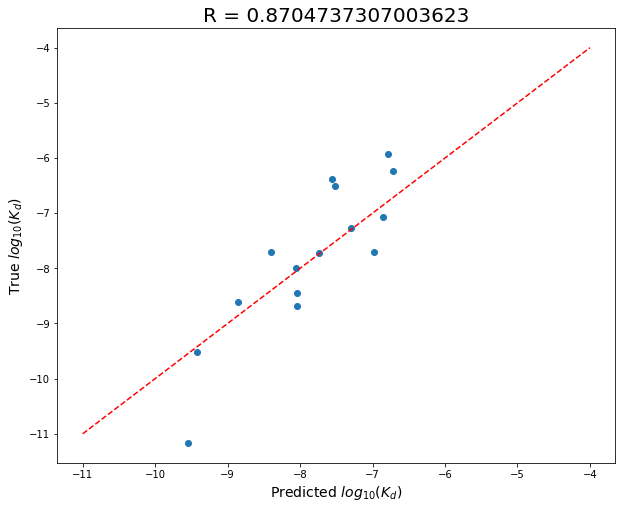

In [966]:
fig = plt.figure(figsize=(10, 8))
plt.scatter(output_test[:,0].detach().numpy(), y_test[:,0].detach().numpy())
corr = np.corrcoef(output_test[:,0].detach().numpy().T, y_test[:,0].detach().numpy().T)[1,0]
plt.plot([-11,-4],[-11,-4], c='r', linestyle='dashed')
plt.title('R = '+str(corr), size=title_size)
plt.xlabel('Predicted $log_{10}$($K_d$)', size=font_size)
plt.ylabel('True $log_{10}$($K_d$)', size=font_size)
plt.show()

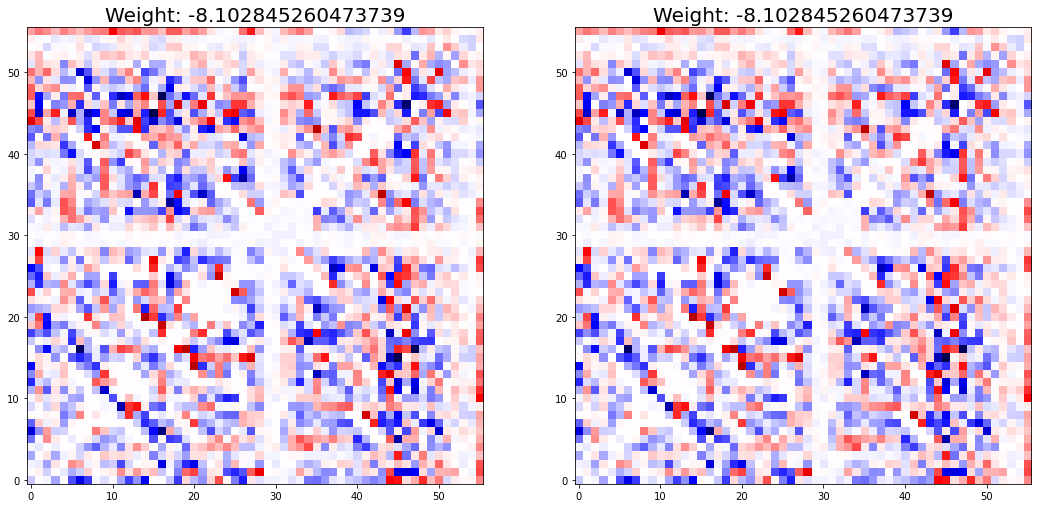

In [967]:
fig, axs = plt.subplots((n_filters+1)//2, 2, figsize=(18, 20))
size_le = int(np.sqrt(model.fc1.weight.data.numpy().shape[-1] / n_filters))
learnt_filter = np.zeros((size_le, size_le))

for i, j in itertools.product(range((n_filters+1)//2), range(2)):
    if j == 1 and i == (n_filters+1)//2-1 and n_filters % 2 != 0:
        im_ = learnt_filter
    else:
        im_ = np.multiply(np.mean(inter_filter, axis=0)[2*i+j], model.fc1.weight.data.numpy().reshape(n_filters,size_le**2)[2*i+j].reshape(size_le, size_le))
        learnt_filter += im_
    im = axs[j].imshow(im_, origin='lower', cmap='seismic', norm=CenteredNorm())
    axs[j].set_title('Weight: '+str(im_.sum()), size=title_size)

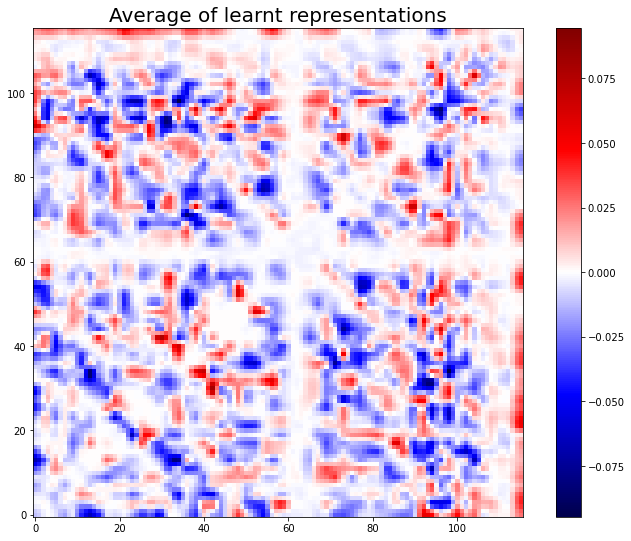

In [968]:
fig = plt.figure(figsize=(12, 9))
plt.imshow(cv2.resize(learnt_filter, dsize=(train_x.shape[2], train_x.shape[2])), origin='lower', cmap='seismic', norm=CenteredNorm())
plt.title('Average of learnt representations', size=title_size)
plt.colorbar()
plt.show()

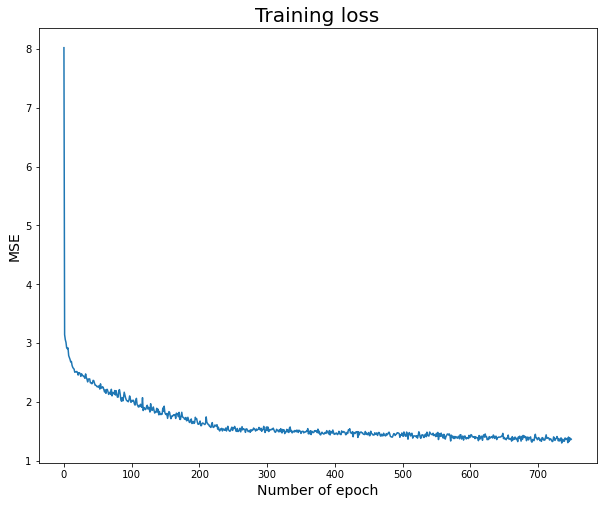

In [956]:
fig = plt.figure(figsize=(10, 8))
plt.plot([train_losses[i] for i in range(len(train_losses))])
plt.title('Training loss', size=title_size)
plt.xlabel('Number of epoch', size=font_size)
plt.ylabel('MSE', size=font_size)
plt.show()

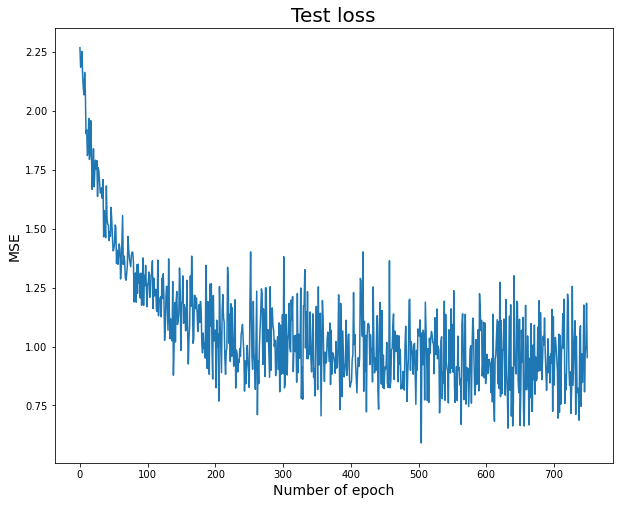

In [957]:
fig = plt.figure(figsize=(10, 8))
plt.plot([test_losses[i].detach().numpy() for i in range(len(test_losses))])
plt.title('Test loss', size=title_size)
plt.xlabel('Number of epoch', size=font_size)
plt.ylabel('MSE', size=font_size)
plt.show()

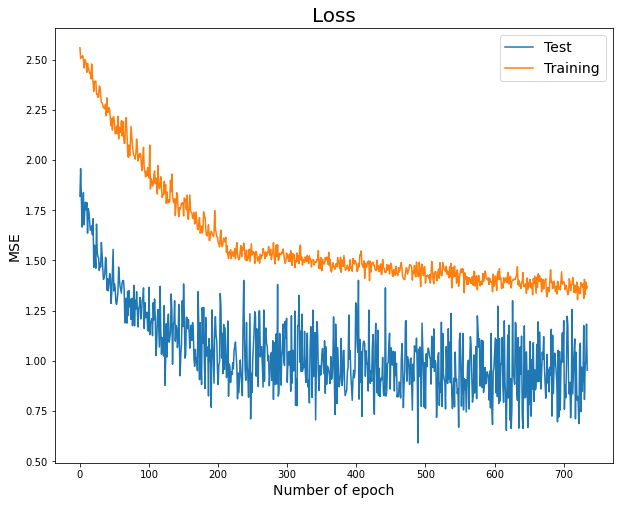

In [958]:
fig = plt.figure(figsize=(10, 8))
plt.plot([test_losses[15:][i].detach().numpy() for i in range(len(test_losses[15:]))])
plt.plot([train_losses[15:][i] for i in range(len(train_losses[15:]))])
plt.title('Loss', size=title_size)
plt.xlabel('Number of epoch', size=font_size)
plt.ylabel('MSE', size=font_size)
plt.legend(['Test', 'Training'], prop={'size': font_size})
plt.show()

In [959]:
model(train_x[40:80])[0]

tensor([[ -8.0761],
        [ -7.9951],
        [ -8.0953],
        [ -7.6781],
        [ -7.9481],
        [ -6.2250],
        [ -8.0315],
        [ -7.0539],
        [ -8.8906],
        [ -7.6486],
        [ -8.2927],
        [ -8.6456],
        [-10.4104],
        [ -7.8381],
        [ -8.3716],
        [ -8.4551],
        [ -7.1012],
        [ -8.0406],
        [ -8.8154],
        [ -8.9797],
        [ -7.7374],
        [ -9.9121],
        [ -7.2194],
        [ -8.4426],
        [ -7.3637],
        [ -8.1476],
        [ -7.8021],
        [ -7.6039],
        [ -7.6045],
        [ -8.3781],
        [ -5.8735],
        [ -7.6277],
        [ -7.5368],
        [ -9.7629],
        [ -7.0419],
        [ -6.9397],
        [ -7.6042],
        [ -6.0384],
        [ -6.7744],
        [ -6.5551]], grad_fn=<MmBackward0>)

In [960]:
train_y[40:80]

tensor([[ -9.0269],
        [ -6.7905],
        [ -9.1759],
        [ -5.3098],
        [ -7.0269],
        [ -6.8539],
        [ -5.7959],
        [ -8.4815],
        [-10.7447],
        [ -8.7645],
        [ -8.5935],
        [ -9.5686],
        [-11.6021],
        [ -8.3010],
        [ -8.2218],
        [ -7.0605],
        [ -6.7799],
        [ -7.7212],
        [ -8.2218],
        [ -8.1871],
        [ -8.1141],
        [-11.2441],
        [ -7.6576],
        [ -9.5376],
        [ -7.3279],
        [ -6.6198],
        [ -6.5391],
        [ -7.8539],
        [ -7.7696],
        [ -8.2518],
        [ -7.0000],
        [ -5.3279],
        [ -6.3872],
        [-10.2676],
        [ -5.0555],
        [ -5.7959],
        [ -8.2147],
        [ -4.6198],
        [ -7.5528],
        [ -6.2218]])

In [969]:
##### Uncomment the following lines to save a checkpoint

#path = '../checkpoints/model_' + regions + '_epochs_' + str(len(train_losses)) + '_modes_' + str(modes) + '_pool_' + str(pooling_size) + '_filters_' + str(n_filters) + '_size_' + str(filter_size) + '.pt'
#save_checkpoint(path, model, optimiser, train_losses, test_losses)
#np.save('../checkpoints/learnt_filter_'+regions+'_epochs_'+str(len(train_losses))+'_modes_'+str(modes)+'_pool_'+str(pooling_size)+'_filters_'+str(n_filters)+'_size_'+str(filter_size)+'.npy', learnt_filter)

In [1097]:
##### Uncomment the following lines to load a checkpoint

from antipasti.utils.torch_utils import load_checkpoint
#
path = '../checkpoints/model_' + regions + '_epochs_' + str(159) + '_modes_' + str(modes) + '_pool_' + str(pooling_size) + '_filters_' + str(n_filters) + '_size_' + str(filter_size) + '.pt'
model,_,_,train_losses, test_losses = load_checkpoint(path, input_shape)

Weight decoupling enabled in AdaBelief
Rectification enabled in AdaBelief
